## Vector Quantized Variational Autoencoder (VQ-VAE)

This repository provides a concise and practical implementation of the **Vector Quantized Variational Autoencoder (VQ-VAE)**, originally introduced by [A. Oord et. al.](https://arxiv.org/pdf/1711.00937.pdf) (2017). Unlike standard VAEs, VQ-VAE replaces the continuous latent space with a **discrete, learnable codebook**, enabling more structured latent representations and sharper reconstructions.

The model is trained on the **CelebA dataset**, a widely used benchmark for generative modeling with face images. Through an encoder–decoder architecture combined with vector quantization, this project explores discrete latent representations, reconstruction fidelity, and sample generation behavior, serving as an accessible tutorial for understanding VQ-VAE fundamentals in practice.

Subsequent sections document the implementation step by step, with explanations accompanying each code cell.

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import os
import json
from utils import * 

DATASET_DIR = "./workdir/celebA_dataset/img_align_celeba"
OUTPUT_DIR = "./workdir/output"

LIM_NUM_IMGS = 2000 # total number  202,599
EPOCHS = 3

BATCH_SIZE = 128
IMG_SIZE = (96, 96) 
INPUT_DIM = 3
HIDDEN_DIM = 512
LATENT_DIM = 16
N_EMBEDDINGS= 512
OUTPUT_DIM = 3
COMMITMENT_BETA = 0.25
LR = 2e-4
PRINT_STEP = 20
TEST_RATIO = 0.2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Assigned device: {DEVICE}")


metrics_json = os.path.join(OUTPUT_DIR, f"training_metrics.json")
model_output = os.path.join(OUTPUT_DIR, f"model_{EPOCHS}_epochs_{LIM_NUM_IMGS}_imgs.pth")

Assigned device: cuda


### 🗂️ Dataset Loading and Data Preparation (`SingleFolderDataset`)

Defines a preprocessing pipeline and a custom dataset class for loading images from a single directory. Images are resized and converted to tensors, then split into training and test subsets. PyTorch `DataLoader`s are created to handle batching and shuffling efficiently during training and evaluation, with basic dataset statistics printed for verification.

In [2]:
data_transform = transforms.Compose([transforms.Resize(IMG_SIZE), transforms.ToTensor()])
kwargs = {'num_workers': 0, 'pin_memory': torch.cuda.is_available() and not torch.backends.mps.is_available()}

dataset = SingleFolderDataset(root=DATASET_DIR, transform=data_transform, img_lim=LIM_NUM_IMGS)
train_size = int((1-TEST_RATIO) * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=BATCH_SIZE, shuffle=False, **kwargs)

print(f"Training: {len(train_loader.dataset)} images in {len(train_loader)} batches of size {BATCH_SIZE}.")
print(f"Test: {len(test_loader.dataset)} images in {len(test_loader)} batches of size {BATCH_SIZE}.")

Training: 1600 images in 13 batches of size 128.
Test: 400 images in 4 batches of size 128.


### 🧠 Vector Quantized Variational AutoEncoder (VQ-VAE) Architecture

This section defines the full **VQ-VAE model**, consisting of an **encoder**, a **vector-quantization codebook with EMA updates**, and a **decoder**.

**Encoder** (`Encoder`)
- Uses strided convolutions to downsample the input image into a compact latent feature map.
- Residual convolution blocks improve representation learning and stability.
- A final projection layer maps features into the latent embedding space expected by the codebook.

**Vector Quantization Codebook (EMA-based)** (`VQEmbeddingEMA`)
- Replaces the continuous latent space of a standard VAE with a **discrete set of learnable embeddings**.
- Each encoder output is mapped to its nearest codebook vector via Euclidean distance.
- Codebook vectors are updated using **Exponential Moving Average (EMA)** instead of gradient descent, improving stability.
- Produces:
  - **Quantized latent representation**
  - **Commitment loss** (encourages encoder outputs to stay close to selected embeddings)
  - **Codebook loss** (aligns embeddings with encoder outputs)
  - **Perplexity** (measures how effectively the codebook is being utilized)

**Decoder** (`Decoder`)
- Reconstructs images from the quantized latent codes using transposed convolutions.
- Residual connections help preserve spatial details during upsampling.

**End-to-End Model** (`Model`)
- The encoder compresses inputs into discrete latent codes.
- The codebook enforces quantization and discrete representation learning.
- The decoder reconstructs images from these discrete representations.

**Key Hyperparameters**
- `n_embeddings`: Number of discrete vectors in the codebook (codebook size)
- `embedding_dim`: Dimensionality of each codebook vector
- `commitment_cost`: Weight for the encoder commitment loss
- `decay`: EMA decay rate for stable codebook updates
- `epsilon`: Small constant for numerical stability

This architecture enables **discrete latent learning**, making VQ-VAE well-suited for **compression, high-quality reconstruction, and generative modeling**.

In [3]:
encoder = Encoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, output_dim=LATENT_DIM)
codebook = VQEmbeddingEMA(n_embeddings=N_EMBEDDINGS, embedding_dim=LATENT_DIM)
decoder = Decoder(input_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

model = Model(Encoder=encoder, Codebook=codebook, Decoder=decoder).to(DEVICE)

In [4]:
mse_loss = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=LR)

### 🏋️ Training the VQ-VAE Model

Trains the VQ-VAE using mini-batch gradient descent over multiple epochs. For each batch, the model reconstructs the input images and computes the total loss as a combination of reconstruction loss, commitment loss (weighted by `commitment_beta`), and codebook loss. Gradients are backpropagated and model parameters are updated accordingly. Periodic logging reports reconstruction quality, codebook utilization (perplexity), and loss components to monitor training behavior.

In [10]:
model.train()
for epoch in range(EPOCHS):
    for batch_idx, x in enumerate(train_loader):
        x = x.to(DEVICE)
        optimizer.zero_grad()
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)
        recon_loss = mse_loss(x_hat, x)
        loss = recon_loss + commitment_loss * COMMITMENT_BETA + codebook_loss
        loss.backward()
        optimizer.step()
        if batch_idx % PRINT_STEP == 0:
            print(
                f"epoch: {epoch + 1} (batch {batch_idx + 1}) "
                f"recon_loss: {recon_loss.item():.3f}  "
                f"perplexity: {perplexity.item():.3f}  "
                f"commit_loss: {commitment_loss.item():.3f} "
                f"codebook_loss: {codebook_loss.item():.3f}  "
                f"total_loss: {loss.item():.3f}\n")

epoch: 1 (batch 1) recon_loss: 0.025  perplexity: 120.763  commit_loss: 0.044 codebook_loss: 0.175  total_loss: 0.211

epoch: 1 (batch 11) recon_loss: 0.016  perplexity: 212.063  commit_loss: 0.036 codebook_loss: 0.145  total_loss: 0.171

epoch: 2 (batch 1) recon_loss: 0.015  perplexity: 261.558  commit_loss: 0.038 codebook_loss: 0.151  total_loss: 0.175

epoch: 2 (batch 11) recon_loss: 0.014  perplexity: 237.090  commit_loss: 0.035 codebook_loss: 0.140  total_loss: 0.163

epoch: 3 (batch 1) recon_loss: 0.013  perplexity: 223.156  commit_loss: 0.034 codebook_loss: 0.137  total_loss: 0.159

epoch: 3 (batch 11) recon_loss: 0.013  perplexity: 250.447  commit_loss: 0.033 codebook_loss: 0.133  total_loss: 0.154



### 🔍 Model Evaluation on the Test Set

Loads a pretrained VQ-VAE checkpoint and evaluates it on the test dataset. The model is run in evaluation mode with gradient computation disabled. For each batch, codebook perplexity, commitment loss, and codebook loss are accumulated and averaged across all test batches. These metrics provide insight into reconstruction behavior, codebook utilization, and the stability of the learned discrete latent representations.

In [5]:
model_dir = os.path.join(OUTPUT_DIR, "model_500_epochs_202599_imgs.pth")
model.load_state_dict(torch.load(model_dir, map_location=DEVICE,weights_only=False))
model.to(DEVICE)

model.eval()
total_perplexity, total_commitment_loss, total_codebook_loss = 0, 0, 0
num_batches = 0

with torch.no_grad():
    for batch_idx, x in enumerate(tqdm(test_loader)):
        x = x.to(DEVICE)
        x_hat, commitment_loss, codebook_loss, perplexity = model(x)

        total_perplexity += perplexity.item()
        total_commitment_loss += commitment_loss.item()
        total_codebook_loss += codebook_loss.item()
        num_batches += 1

avg_perplexity = total_perplexity / num_batches
avg_commitment_loss = total_commitment_loss / num_batches
avg_codebook_loss = total_codebook_loss / num_batches

print(f"Average metrics over {num_batches} batches:")
print(f"Perplexity: {avg_perplexity:.3f}, Commitment loss: {avg_commitment_loss:.3f}, Codebook loss: {avg_codebook_loss:.3f}")

100%|██████████| 4/4 [00:01<00:00,  3.90it/s]

Average metrics over 4 batches:
Perplexity: 364.130, Commitment loss: 0.008, Codebook loss: 0.032


### 🖼️ Visualizing Reconstructions

Displays a side-by-side comparison of ground-truth images and their corresponding reconstructions produced by the VQ-VAE. Images are arranged into grids for compact visualization, with rows representing original inputs and reconstructed outputs. This qualitative comparison helps assess reconstruction fidelity and visual quality of the learned discrete representations.

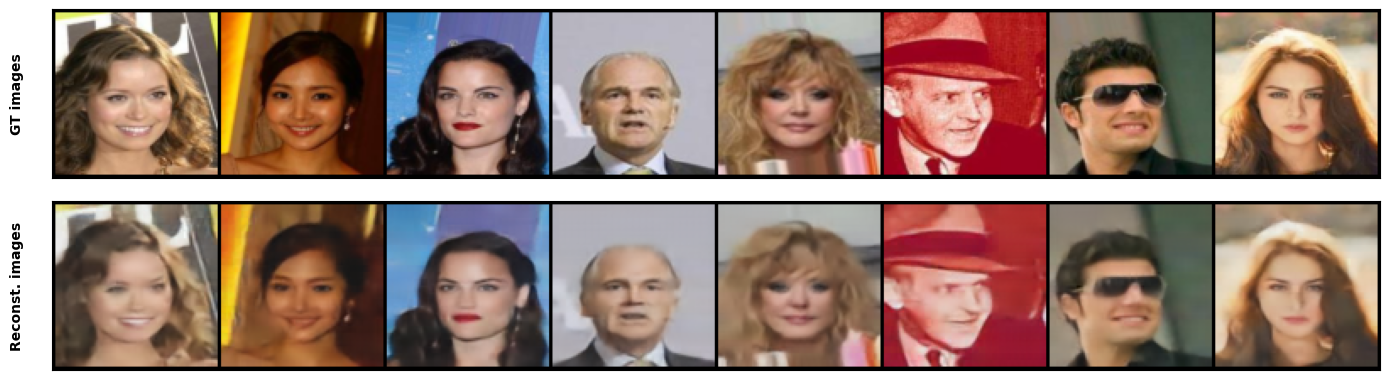

In [6]:
num_imgs = 8
x1, x_hat1 = x[:num_imgs], x_hat[:num_imgs]
plot_sample_image(x1, x_hat1)

### 🎨 Generating Samples from the VQ-VAE Codebook

Generates and visualizes images from the trained VQ-VAE under different latent manipulation modes. Given real input images, the encoder maps them to discrete codebook indices, which are then modified depending on the selected mode before decoding:

- **Random**: Replaces latent indices with random codebook entries to generate novel samples.
- **Reconstruct**: Uses the original encoded indices to reconstruct the input images.
- **Perturb**: Randomly alters a fraction of latent indices to introduce controlled variation.
- **Interpolate**: Blends latent codes between pairs of samples to observe smooth transitions.

The resulting outputs are plotted alongside the original inputs, enabling qualitative comparison of reconstruction quality and generative behavior under each manipulation strategy.

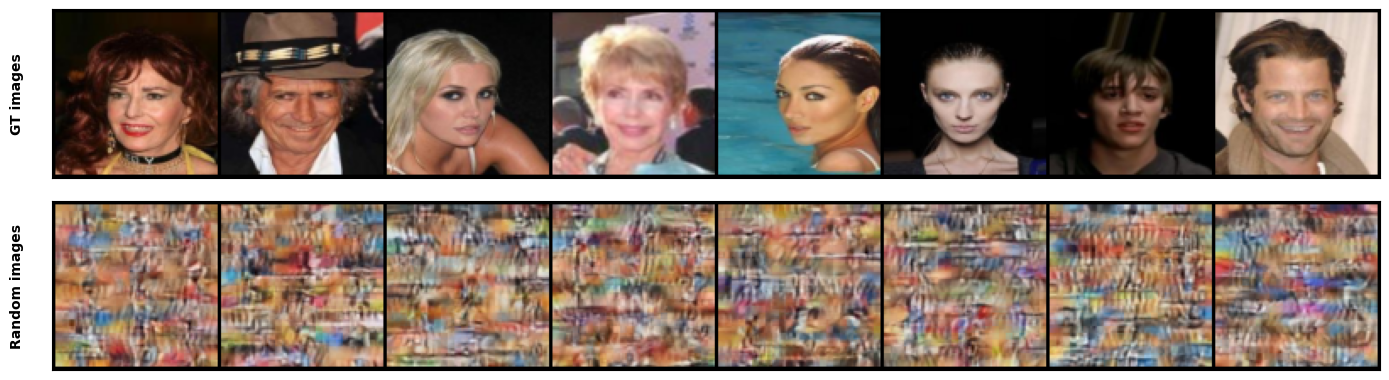

In [7]:
num_samples = 8
batch = next(iter(test_loader))
x_real = batch[torch.randperm(batch.size(0))[:num_samples], :, :, :]

generate_samples_with_mode(encoder, codebook, decoder, x_real, DEVICE, mode="Random")

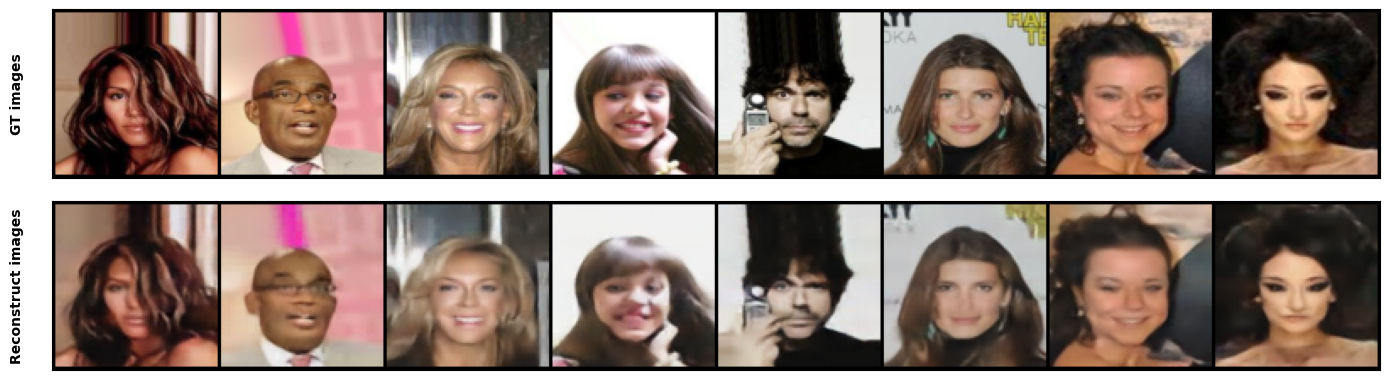

In [8]:
num_samples = 8
batch = next(iter(test_loader))
x_real = batch[torch.randperm(batch.size(0))[:num_samples], :, :, :]

generate_samples_with_mode(encoder, codebook, decoder, x_real, DEVICE, mode="Reconstruct")

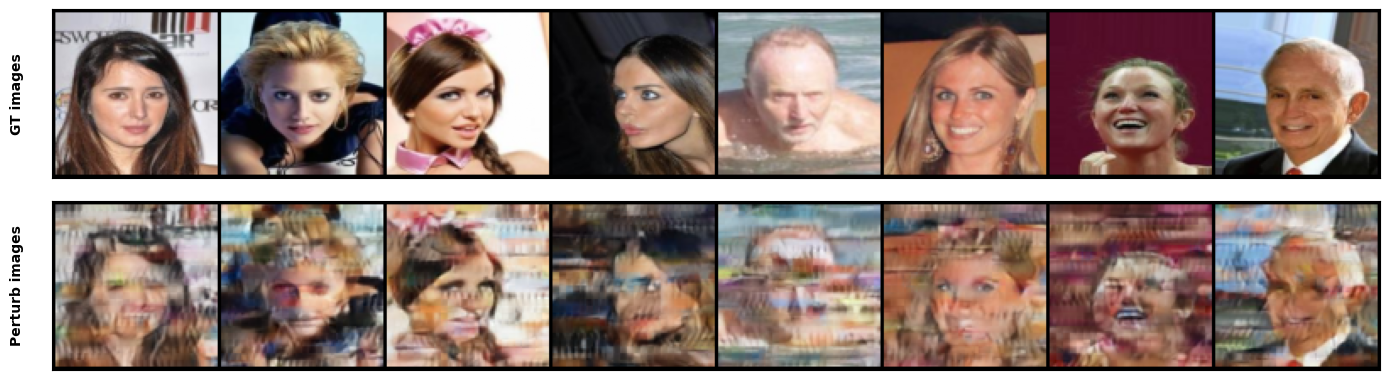

In [9]:
num_samples = 8
batch = next(iter(test_loader))
x_real = batch[torch.randperm(batch.size(0))[:num_samples], :, :, :]

generate_samples_with_mode(encoder, codebook, decoder, x_real, DEVICE, mode="Perturb")

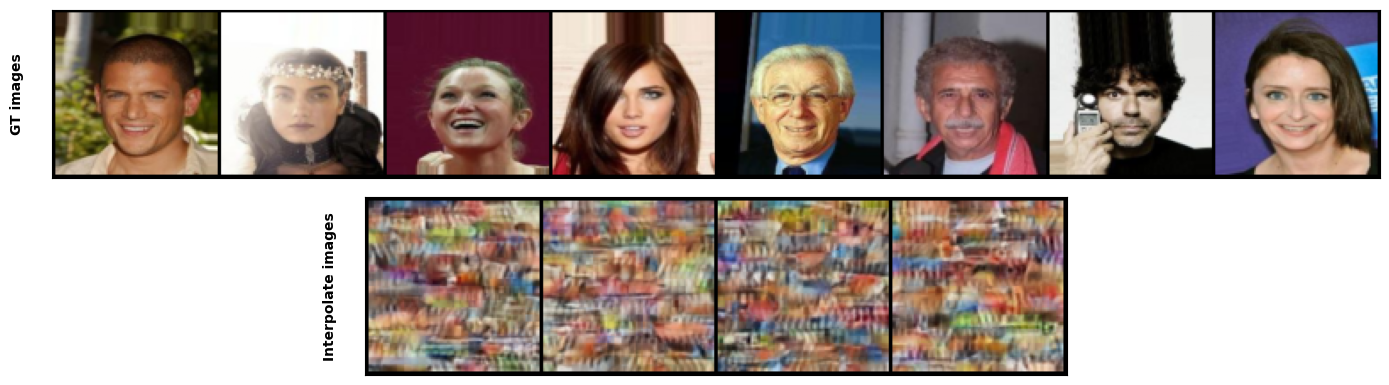

In [10]:
num_samples = 8
batch = next(iter(test_loader))
x_real = batch[torch.randperm(batch.size(0))[:num_samples], :, :, :]

figure = generate_samples_with_mode(encoder, codebook, decoder, x_real, DEVICE, mode="Interpolate")

### 📈 Visualizing Training Metrics from a JSON Log

Loads a JSON file containing recorded training metrics (e.g., losses or scores over iterations) and visualizes each metric in a dedicated subplot. Each curve is plotted with consistent styling and labeling to enable clear comparison of learning dynamics across metrics. This function is useful for post-training analysis when metrics are saved during training and need to be inspected or reported without rerunning experiments.

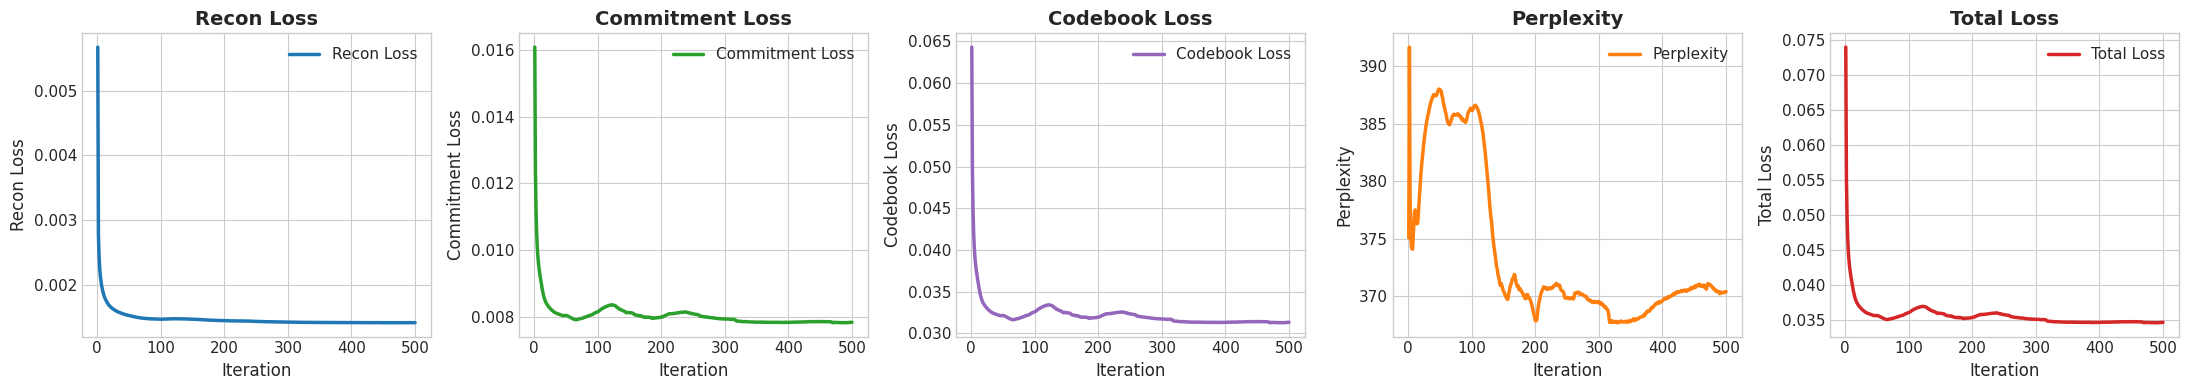

In [13]:
json_dir = os.path.join(OUTPUT_DIR, f"training_metrics.json")
plot_json_learning_curves(json_dir)

---
© Ashkan M., NTNU  
Released under the MIT License
---